## 1. Project Title & Team Information

**Title:** Accident Risk Analysis: Urban vs. Rural Populations

**Team Members:** Dave Woodford, Tim Mai, Matt Dolin, and Phillip Roman

### Team Background and Contributions

- **Phillip Roman** is a graduate student in the MSDS program, transitioning from a career in industrial telecommunications to data science with a focus on Predictive Maintenance. His technical stack includes Python and core data analysis libraries such as NumPy, Pandas, and SciPy. Drawing on his background in airfield systems maintenance, Phillip contributed to the team's Exploratory Data Analysis (EDA), focusing on identifying patterns in equipment failure and infrastructure variables, as well as statistical testing of environmental differences.

- **Tim Mai** is a graduate student in the MSDS program. Technical skills include developing statistical analysis and models using Python libraries: numpy, pandas, and matlib.plot. Utilizing his previous experience in data modeling, Tim assisted in the EDA by cleaning and merging the datasets. 

- **Matt Dolin** is a graduate student in the MSDS program, with a focus on Applied AI/ML. He has experience using Python and R to visualize and transform data for use in training machine learning models. Matt's tech stack includes Python (Pandas, Plotly, Scikit-Learn), R, and SQL. Matt drew on his prior analytical experience to assist in the EDA by creating interactive visualizations and determining correlations between features and target columns.

- **Dave Woodford** [your teammate can fill this in]

## 2. Project Definition & Motivation

### Objective: 
"Does accident frequency increase in high-population counties? Do factors differ between rural and metro areas?"

### Stakeholders: 
* Department of Transportation
* Railroad Administration
* Railroad companies
* Local municipaliteis
* The Public

### Potential Application: 
A risk-assessment tool or "safe travel" dashboard


# 3. Data Preparation: Sources, Cleaning, and Merge

To investigate the relationship between population density and rail safety, we selected two primary datasets that allow for a granular geospatial analysis at the county level.

## 3a. Data Sources and Selection

### **Source A: Rail Equipment Accident/Incident Data (Form 54)**
* **Publisher:** Federal Railroad Administration (FRA) / Department of Transportation (DOT)
* **Period:** 2012 - Present (Filtered for schema consistency)
* **URL:** [DOT Open Data Portal](https://data.transportation.gov/Railroads/Rail-Equipment-Accident-Incident-Data-Form-54-/85tf-25kj/about_data)
* **Justification & Selection Criteria:**
    * **Authoritative Record:** This dataset is the federal standard for reportable rail accidents.
    * **Reporting Threshold:** We acknowledge that this dataset excludes minor incidents. Inclusion is based on a monetary reporting threshold (adjusted annually for inflation, approx. $12,000+ in recent years), ensuring our analysis focuses on events with significant economic impact or infrastructure damage.
    * **Temporal Cut-off:** We restricted our analysis to data starting from **2012**. While the FRA updated their reporting schema in June 2011, we excluded the entire transition year to ensure maximum data integrity and consistent definitions for key variables like `TERRITORY`.

### **Source B: Rural-Urban Continuum Codes (2023)**
* **Publisher:** USDA Economic Research Service (ERS)
* **Period:** 2023 Edition
* **URL:** [USDA ERS Data Products](https://www.ers.usda.gov/data-products/rural-urban-continuum-codes)
* **Justification (USDA vs. US Census):**
    * **Superior Granularity:** Standard US Census data relies on simple population counts. The USDA RUCC system classifies counties into a 9-point scale based on distinct *environmental* factors.
    * **The "Adjacency" Factor:** Crucially, this dataset distinguishes rural counties by their **adjacency to metropolitan areas**. This is vital for our analysis, as we hypothesize that rural counties adjacent to major transit hubs face different rail traffic risks than isolated rural counties—a nuance that standard census counts would miss.

## 3b. Libraries & Data Loading

In [5]:
# Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr, f, entropy, chi2_contingency
from scipy.spatial.distance import cosine as cosine_dist

sns.set_theme(style="whitegrid")

# Load data
rail_accident_path = "../data/raw/Rail_Equipment_Accident_Incident_Data_(Form_54)_20260114.csv.zip"
population_path = "../data/raw/Ruralurbancontinuumcodes2023.csv"

df_accident_all = pd.read_csv(
    rail_accident_path,
    low_memory=False
)

df_population = pd.read_csv(
    population_path,
    encoding="latin1"
)

# Checks
print(f"Rail Data Loaded. Shape: {df_accident_all.shape}")
print(f"Population Data Loaded. Shape: {df_population.shape}")
print()
display(df_accident_all.head(3))
print()
display(df_population.head(3))

Rail Data Loaded. Shape: (223529, 155)
Population Data Loaded. Shape: (9703, 5)



,Reporting Railroad Code,Reporting Railroad Name,Year,Accident Number,PDF Link,Accident Year,Accident Month,Other Railroad Code,Other Railroad Name,Other Accident Number,...,Reporting Parent Railroad Name,Reporting Railroad Holding Company,Reporting Railroad Individual Class,Reporting Railroad Passenger,Reporting Railroad Commuter,Reporting Railroad Switching Terminal,Reporting Railroad Tourist,Reporting Railroad Freight,Reporting Railroad Short Line,Location
0,SOO,SOO Line Railroad Company,1981,CA28,https://safetydata.fra.dot.gov/Officeofsafety/...,81,8,NaN,NaN,NaN,...,CANADIAN PACIFIC KANSAS CITY,Not Assigned,Unassigned,Unassigned,Unassigned,Unassigned,Unassigned,Unassigned,Unassigned,NaN
1,MP,Missouri Pacific Railroad Company,1981,81230,https://safetydata.fra.dot.gov/Officeofsafety/...,81,9,NaN,NaN,NaN,...,Union Pacific Railroad Company,Union Pacific Railroad Company,Not Assigned,Not Assigned,Not Assigned,Not Assigned,Not Assigned,Not Assigned,Not Assigned,NaN
2,SP,Southern Pacific Transportation Company,1980,W1200,https://safetydata.fra.dot.gov/Officeofsafety/...,80,1,NaN,NaN,NaN,...,Union Pacific Railroad Company,Union Pacific Railroad Company,Not Assigned,Not Assigned,Not Assigned,Not Assigned,Not Assigned,Not Assigned,Not Assigned,NaN


,FIPS,State,County_Name,Attribute,Value
0,1001,AL,Autauga County,Population_2020,58805
1,1001,AL,Autauga County,RUCC_2023,2
2,1001,AL,Autauga County,Description,"Metro - Counties in metro areas of 250,000 to ..."


### 3c. Data Cleaning

Our analysis requires merging two disparate datasets that lack a common unique identifier in their raw state. The Rail Accident data uses separate columns for "State" and "County," while the Census data uses a unified 5-digit FIPS code.

**Data Cleaning Pipeline:**
1.  **Temporal Filtering:** We filtered the dataset to include only years **> 2011**, avoiding the schema inconsistencies of the pre-2011 reporting standards.
2.  **Null Removal:** Rows with missing "County Code" identifiers were removed to ensure accurate geospatial mapping, as these records cannot be linked to census data.
3.  **FIPS Construction:** We synthesized a 5-digit Federal Information Processing Standard (FIPS) code for the rail data by padding the State Code (2 digits) and County Code (3 digits).
4.  **Pivoting:** The Census data was pivoted from a "Long" format (multiple rows per county) to a "Wide" format (one row per county) to expose `Population_2020` and `Description` as distinct columns.

In [7]:
df_accident = df_accident_all.copy()

# Filter for accidents after 2011
df_accident = df_accident[df_accident["Year"] > 2011]

# Clean railroad accident data
df_accident = df_accident.dropna(subset=["County Code"])
df_accident["State Code FIPS"] = df_accident["State Code"].astype(int).astype(str).str.zfill(2)
df_accident["County Code FIPS"] = df_accident["County Code"].astype(int).astype(str).str.zfill(3)
df_accident["FIPS"] = (df_accident["State Code FIPS"] + df_accident["County Code FIPS"]).astype(int)

# Clean population data
df_population_wide = df_population.pivot(index="FIPS", columns="Attribute", values="Value").reset_index()
df_population_wide["FIPS"] = df_population_wide["FIPS"].astype(int)
df_population_wide.columns.name = None

# Verify population is numeric - remove if not
if "Population_2020" in df_population_wide.columns:
    df_population_wide["Population_2020"] = (
        pd.to_numeric(df_population_wide["Population_2020"].astype(str).str.replace(",", ""), errors="coerce")
    )

# Checks
print("Railroad Data: FIPS Check")
cols_to_verify = ["State Code", "County Code", "State Code FIPS", "County Code FIPS", "FIPS"]
display(df_accident[cols_to_verify].head())

print("\nPopulation Data: Pivot Check - wide")
display(df_population_wide.head())

Railroad Data: FIPS Check


,State Code,County Code,State Code FIPS,County Code FIPS,FIPS
50,53,53.0,53,053,53053
54,21,15.0,21,015,21015
56,47,37.0,47,037,47037
58,45,47.0,45,047,45047
1159,12,99.0,12,099,12099



Population Data: Pivot Check - wide


,FIPS,Description,Population_2020,RUCC_2023
0,1001,"Metro - Counties in metro areas of 250,000 to ...",58805,2
1,1003,Metro - Counties in metro areas of fewer than ...,231767,3
2,1005,"Nonmetro - Urban population of 5,000 to 20,000...",25223,6
3,1007,Metro - Counties in metro areas of 1 million p...,22293,1
4,1009,Metro - Counties in metro areas of 1 million p...,59134,1


### 3d. Data Merge

We merged the Rail Accident data with the Census data using a **Left Join** on the generated `FIPS` key.

* **Linkage:** Accidents were matched to their corresponding county population and rural-urban classification.
* **Exclusion of Unmatched Records:** Following the merge, we removed any accident records that failed to match with a valid census entry (i.e., where `Population_2020` was null). This step is necessary because accidents occurring in unidentified counties cannot be normalized for follow-on per-capita risk analysis.

In [9]:
# Merge
df_merged = pd.merge(
    df_accident,
    df_population_wide,
    on="FIPS",
    how="left"
)

# Drop rows/accidents where population is blank
df_merged = df_merged.dropna(subset=["Population_2020"])

# Checks
print(f"Merged Shape: {df_merged.shape}")
print("New columns available:", list(df_population_wide.columns))
cols_to_show = ["FIPS", "State Name", "Description", "Population_2020"]
display(df_merged[cols_to_show].head())

Merged Shape: (34562, 161)
New columns available: ['FIPS', 'Description', 'Population_2020', 'RUCC_2023']


,FIPS,State Name,Description,Population_2020
0,53053,WASHINGTON,Metro - Counties in metro areas of 1 million p...,921130.0
1,21015,KENTUCKY,Metro - Counties in metro areas of 1 million p...,135968.0
2,47037,TENNESSEE,Metro - Counties in metro areas of 1 million p...,715884.0
3,45047,SOUTH CAROLINA,"Nonmetro - Urban population of 20,000 or more,...",69351.0
4,12099,FLORIDA,Metro - Counties in metro areas of 1 million p...,1492191.0


## 4. Baseline Statistical Profile

Before jumping into visualizations, we need to understand the basic statistical properties of our data. This helps us know if we're dealing with a few extreme outliers or if accidents are spread out across counties.

### 4.1a Central Tendency Analysis

In [12]:
accident_counts = df_merged.groupby("FIPS").size() # per county

county_stats = df_merged.groupby("FIPS").agg({
    "Population_2020": "first",
    "Description": "first",
    "RUCC_2023": "first" 
})
county_stats["Total_Accidents"] = df_merged.groupby("FIPS").size()

# Base stats
mean_accidents = accident_counts.mean()
median_accidents = accident_counts.median()
std_accidents = accident_counts.std()
variance = accident_counts.var()

print("=== Central Tendency ===")
print(f"Mean accidents per county: {mean_accidents:.2f}")
print(f"Median accidents per county: {median_accidents}")
print(f"Standard Deviation: {std_accidents:.2f}")
print(f"Variance: {variance:.2f}")

# Calculate coefficient of variation to see how spread out things are
cv = (std_accidents / mean_accidents) * 100
print(f"\nCoefficient of Variation: {cv:.1f}%")

# Quick interpretation
if cv > 50:
    print("High variation - a few counties drive most accidents")
elif cv < 30:
    print("Low variation - accidents are fairly consistent across counties")
else:
    print("Moderate variation - some outliers but not extreme")

=== Central Tendency ===
Mean accidents per county: 16.30
Median accidents per county: 5.0
Standard Deviation: 50.59
Variance: 2559.77

Coefficient of Variation: 310.5%
High variation - a few counties drive most accidents


### 4.1b Central Tendency Interpretation

The coefficient of variation tells us how unpredictable accident counts are across counties. A high CV (>50%) means we have some extreme outliers that are driving up the average, which makes sense since major metro areas probably have way more accidents than tiny rural counties.

### 4.2a Correlation: Pearson vs Spearman Correlation

Pearson measures linear relationships while Spearman measures any monotonic relationship (doesn't have to be a straight line). If they're close, the relationship is straightforward. If Spearman is noticeably different, it means there might be some non-linear patterns we should explore.

In [15]:
# Pearson vs Spearman Correlation

# Pearson (from before)
pearson_corr = county_stats["Total_Accidents"].corr(county_stats["Population_2020"])

# Spearman - checks monotonic relationships (doesn't assume linearity)
spearman_corr, p_value = spearmanr(
    county_stats["Population_2020"], 
    county_stats["Total_Accidents"]
)

print("\n=== Correlation Analysis ===")
print(f"Pearson Correlation: {pearson_corr:.3f}")
print(f"Spearman Correlation: {spearman_corr:.3f}")
print(f"Difference: {abs(spearman_corr - pearson_corr):.3f}")

# TODO: Could add a scatter plot colored by RUCC code to visualize this better

if abs(spearman_corr - pearson_corr) < 0.05:
    print("\nBoth correlations are similar - relationship is pretty linear")
else:
    print(f"\nSpearman is {'higher' if spearman_corr > pearson_corr else 'lower'} than Pearson")
    print("This suggests the relationship might not be perfectly linear")


=== Correlation Analysis ===
Pearson Correlation: 0.589
Spearman Correlation: 0.478
Difference: 0.110

Spearman is lower than Pearson
This suggests the relationship might not be perfectly linear


### 4.2b Correlation Comparison Findings
The correlations differ notably (Δ = 0.110), indicating that population and accidents have a **non-linear** relationship. The lower Spearman suggests the relationship weakens at the extremes (very large or very small counties). This sets up our visual analysis in Section 5.

## 5. Volume Correlation Analysis

### 5.1a Population vs Accidents Scatterplot

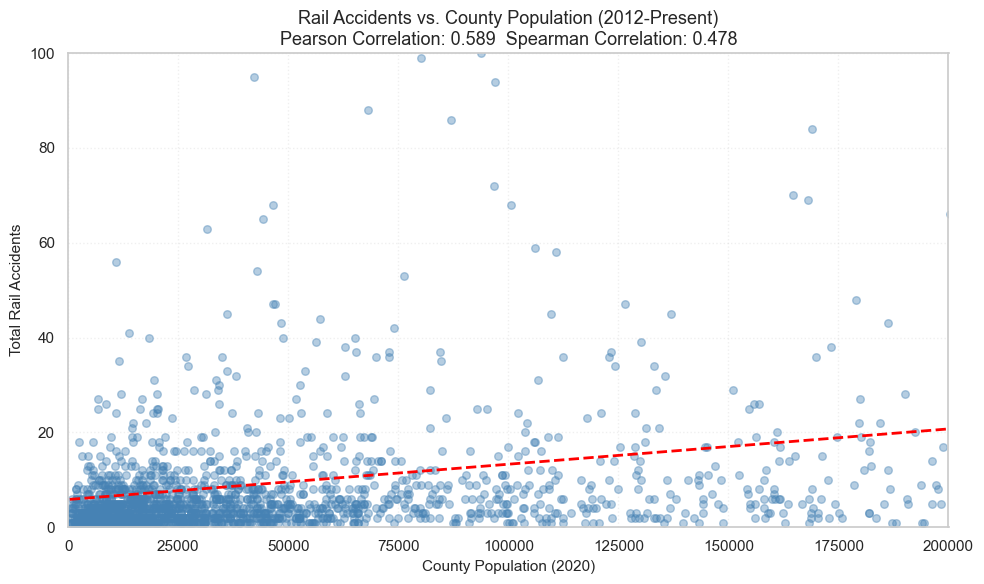

In [19]:
# Scatterplot: Correlation population vs accident volume

# Calculate Perason correlation
correlation = county_stats["Total_Accidents"].corr(county_stats["Population_2020"])

# Scatterplot 
plt.figure(figsize=(10, 6))

plt.scatter(
    county_stats["Population_2020"], 
    county_stats["Total_Accidents"],
    alpha=0.4,
    s=30,
    color='steelblue'
)

# Regression line
sns.regplot(
    data=county_stats, 
    x="Population_2020", 
    y="Total_Accidents", 
    scatter=False, 
    color="red",
    ci=None,
    line_kws={"linestyle": "--", "linewidth": 2}
)

plt.xlim(0, 200000)
plt.ylim(0, 100)
plt.title(f"Rail Accidents vs. County Population (2012-Present)\nPearson Correlation: {correlation:.3f}  Spearman Correlation: {spearman_corr:.3f}", 
          fontsize=13)
plt.xlabel("County Population (2020)", fontsize=11)
plt.ylabel("Total Rail Accidents", fontsize=11)
plt.grid(True, alpha=0.3, linestyle=':')
plt.tight_layout()
plt.show()



### 5.1b Interpretation: Volume vs. Risk

**1. The Volume View (Baseline)**
The scatterplot above examines counties with populations under 200,000—where the vast majority of U.S. counties fall. Even within this focused range, we observe a moderate positive correlation (**r = 0.59**) between county population and total accident count. This confirms our initial hypothesis: more people and rail activity generally lead to more accidents in absolute terms.

**2. The Risk View (The Pivot)**
However, raw accident counts don't tell the full story. When we normalize by population to calculate *risk intensity* (accidents per 100,000 residents), the pattern reverses dramatically. The bar chart below reveals that smaller, rural counties—especially those isolated from metropolitan areas—face significantly higher per-capita accident rates than their urban counterparts.

## 6. Risk Normalization & Environmental Comparison

Now that we've confirmed the population-accident correlation exists, we need to test whether metro and rural counties are actually different from each other, or if population size is the only thing that matters.

In [22]:
# Testing if Metro vs Rural counties have different accident patterns

# Split counties into metro (codes 1-3) and rural (codes 4-9)
metro_codes = ['1', '2', '3'] 
rural_codes = ['4', '5', '6', '7', '8', '9']

# Get accident counts for each environment
metro_counties = county_stats[county_stats['RUCC_2023'].isin(metro_codes)]['Total_Accidents']
rural_counties = county_stats[county_stats['RUCC_2023'].isin(rural_codes)]['Total_Accidents']

print("=== Metro vs Rural Variance Test ===\n")
print(f"Metro counties (n={len(metro_counties)}):")
print(f"  Mean: {metro_counties.mean():.2f}")
print(f"  Variance: {metro_counties.var():.2f}")
print(f"  Std Dev: {metro_counties.std():.2f}")

print(f"\nRural counties (n={len(rural_counties)}):")
print(f"  Mean: {rural_counties.mean():.2f}")
print(f"  Variance: {rural_counties.var():.2f}")
print(f"  Std Dev: {rural_counties.std():.2f}")

# F-test
f_stat = metro_counties.var() / rural_counties.var()
df1 = len(metro_counties) - 1
df2 = len(rural_counties) - 1
p_val = 1 - f.cdf(f_stat, df1, df2)

print(f"\nF-statistic: {f_stat:.2f}")
print(f"p-value: {p_val:.4f}")

if p_val < 0.05:
    print("Variances are significantly different (p < 0.05)")
    print("Metro and rural counties have fundamentally different patterns")
else:
    print("Variances are not significantly different")
    print("Population size might be the only thing that matters")

=== Metro vs Rural Variance Test ===

Metro counties (n=939):
  Mean: 27.89
  Variance: 5068.04
  Std Dev: 71.19

Rural counties (n=1182):
  Mean: 7.08
  Variance: 377.79
  Std Dev: 19.44

F-statistic: 13.41
p-value: 0.0000
Variances are significantly different (p < 0.05)
Metro and rural counties have fundamentally different patterns


### 6.1 Interpretation: Are Environments Different?

The F-test compares the variance (spread) of accident counts between metro and rural counties. If the variances are significantly different, it means these two environments behave differently - it's not just about having more or fewer people.

**Result:** F-statistic = 13.41, p-value < 0.0001

This **does** provide statistical evidence that metro and rural counties are fundamentally different. The variance in metro counties (5068.04) is over 13 times larger than in rural counties (377.79), and this difference is highly significant (p < 0.0001).

What this means: Metro counties show much more variability in their accident counts - some have very few accidents while others have extremely high counts. Rural counties are more consistent, with most falling in a narrower range around their mean (7.08 accidents). This suggests that environmental factors beyond just population size influence accident patterns. 

This finding justifies looking at per-capita rates instead of just raw counts - the different variance structures indicate that the relationship between population and accidents isn't the same across both environments.

### 6.2 Per-Capita Risk Analysis by Environment Type

Having established that metro and rural counties exhibit statistically different accident patterns, we now normalize accident counts by population to calculate risk intensity. This addresses a key limitation of raw volume analysis: larger populations naturally experience more accidents simply due to scale.

By calculating accidents per 100,000 residents for each USDA Rural-Urban Continuum Code category, we can compare risk exposure across environments of vastly different sizes. This metric reveals whether the elevated accident counts in metro areas are proportional to their populations, or if certain environment types bear disproportionate per-capita risk.

The bar chart below displays risk rates sorted from highest to lowest, with RUCC codes (1-9) prefixed to each category label for reference.

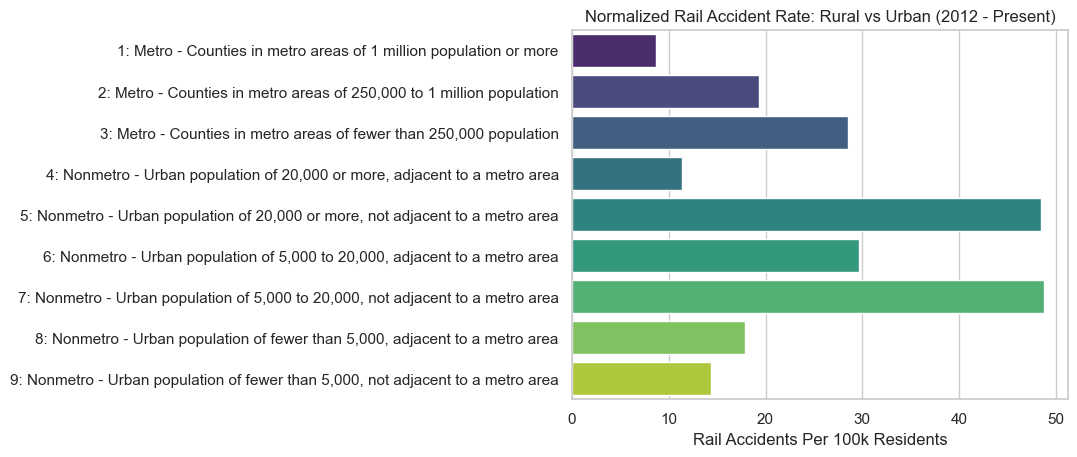

RUCC Population/Accidents Table:


,USDA_Category,Total_Accidents,Accidents_Per_100k
0,1: Metro - Counties in metro areas of 1 millio...,15601,8.69
1,"4: Nonmetro - Urban population of 20,000 or mo...",6962,11.41
2,9: Nonmetro - Urban population of fewer than 5...,3630,14.40
3,"2: Metro - Counties in metro areas of 250,000 ...",2022,19.31
4,"7: Nonmetro - Urban population of 5,000 to 20,...",1540,48.79
5,8: Nonmetro - Urban population of fewer than 5...,1450,17.87
6,3: Metro - Counties in metro areas of fewer th...,1228,28.53
7,"6: Nonmetro - Urban population of 5,000 to 20,...",1033,29.67
8,"5: Nonmetro - Urban population of 20,000 or mo...",1096,48.42


In [385]:
#Creates a new column, label, that concatenates the RUC Code and Description columns
df_merged['Label'] = (df_merged['RUCC_2023'] + ': ' + df_merged['Description']).astype('category')
df_merged['Location_Class'] = np.where(df_merged['Description'].str.contains('Nonmetro'), 'Rural', 'Urban')
#Calculates accidents per RUC Code value as the counts of each label
accidents_per_ruc = df_merged.groupby('Label', observed = False).size()

#Calculates total population for each RUC Label
#Drop_duplicates is used to select only one population value for each FIPS region
#These rows are then grouped by their Label (RUC Code), and the populations for each label are added together
population_per_ruc = df_merged.drop_duplicates(subset = ['FIPS']).groupby('Label', observed = False)['Population_2020'].sum()
#Calculates accidents per 100k residents as (accidents_per_ruc / population_per_ruc) * 100,000
accidents_per_100k = (accidents_per_ruc / population_per_ruc) * 100000

#Creates a new dataframe out of the columns initialized above
df_ruc = pd.DataFrame({
    'USDA_Category': df_merged['Label'].unique(),
    'Total_Accidents': accidents_per_ruc.values,
    'Accidents_Per_100k': accidents_per_100k.values
})

#Plots a Seaborn barplot of accidents_per_100k by Label/USDA Category
fig = sns.barplot(
    df_ruc, 
    x = 'Accidents_Per_100k',
    y = 'USDA_Category',
    palette="viridis",
    hue="USDA_Category",
    legend=False
)

#Adds relevant title and axis labels to barplot
plt.title('Normalized Rail Accident Rate: Rural vs Urban (2012 - Present)')
plt.xlabel('Rail Accidents Per 100k Residents')
plt.ylabel(None)
plt.show()

#Displays dataframe initialized above
print('RUCC Population/Accidents Table:')
display(df_ruc.round(2))

### 6.2 Interpretation of Initial Findings

While our preliminary data confirmed that urban areas with greater populations have more total accidents, normalizing by population reveals a starkly different risk profile.

* Rural counties show a significantly higher rate of accidents per capita than urban centers. Notably, the risk is highest in isolated rural counties (not adjacent to metros), where the rate (\~48.42 per 100k) is over 5x higher than in major metropolitan areas (\~8.69 per 100k).
* While urban centers handle a greater transit volume, isolated rural areas bear the disproportionate risk of high-speed transit with a minimal population base to support emergency response infrastructure.

## 7. Outlier Identification & Resource Prioritization

Understanding averages is useful, but policy decisions need specifics. Which counties have the highest accident burdens?

In [344]:
#Calculates accidents per FIPS Code value as the counts of each FIPS code
accidents_per_fips = df_merged.groupby('FIPS').size()

#Calculates total population for each FIPS code
population_per_fips = df_merged.groupby('FIPS')['Population_2020'].first()
#Calculates accidents per 100k residents as (accidents_per_fips / population_per_fips) * 100,000
accidents_per_100k = (accidents_per_fips / population_per_fips) * 100000

#Creates a new dataframe out of the columns initialized above
df_fips = pd.DataFrame({
    'Accidents': accidents_per_fips.values,
    'Population': population_per_fips,
    'Accidents_Per_100k': accidents_per_100k.values,
    'RUCC': df_merged.groupby('FIPS')['RUCC_2023'].first(),
    'Description': df_merged.groupby('FIPS')['Description'].first(),
    'Class': df_merged.groupby('FIPS')['Location_Class'].first()
}).reset_index()

#Displays top 5 FIPS regions by total accidents
print('Most Accidents:')
display(df_fips.nlargest(5, 'Accidents'))

#Displays top 5 FIPS regions by normalized accident rate
print('\nMost Accidents Per 100k:')
display(df_fips.nlargest(5, 'Accidents_Per_100k'))

#Calculates the IQR (75th percentile - 25th percentile) for total accidents and total accidents per 100k residents
accident_iqr = df_fips['Accidents'].quantile(0.75) - df_fips['Accidents'].quantile(0.25)
norm_accident_iqr = df_fips['Accidents_Per_100k'].quantile(0.75) - df_fips['Accidents_Per_100k'].quantile(0.25)

#Calculate all outliers above 1.5*IQR for accidents and normalized accidents
accident_outliers = df_fips[df_fips['Accidents'] > df_fips['Accidents'].quantile(0.75) + (1.5 * accident_iqr)]
norm_accident_outliers = df_fips[df_fips['Accidents_Per_100k'] >  df_fips['Accidents_Per_100k'].quantile(0.75) + (1.5 * norm_accident_iqr)]

print('\nEnvironment Breakdown of Total Accident Outliers (>' + str(accident_iqr * 1.5) +' Accidents):')
display(accident_outliers['Class'].value_counts(normalize = True))

print('\nEnvironment Breakdown of Normalized Accident Outliers (>' + str(round(norm_accident_iqr * 1.5, 2)) +' Accidents Per 100k Residents)')
display(norm_accident_outliers['Class'].value_counts(normalize = True))

Most Accidents:


,FIPS,Accidents,Population,Accidents_Per_100k,RUCC,Description,Class
393,17031,1295,5275541.0,24.547245,1,Metro - Counties in metro areas of 1 million p...,Urban
1782,48201,892,4731145.0,18.853787,1,Metro - Counties in metro areas of 1 million p...,Urban
1153,31111,502,34676.0,1447.687161,5,"Nonmetro - Urban population of 20,000 or more,...",Rural
146,6071,475,2181654.0,21.772472,1,Metro - Counties in metro areas of 1 million p...,Urban
25,1073,448,674721.0,66.397815,1,Metro - Counties in metro areas of 1 million p...,Urban



Most Accidents Per 100k:


,FIPS,Accidents,Population,Accidents_Per_100k,RUCC,Description,Class
1153,31111,502,34676.0,1447.687161,5,"Nonmetro - Urban population of 20,000 or more,...",Rural
774,22077,205,20758.0,987.571057,2,"Metro - Counties in metro areas of 250,000 to ...",Urban
2113,56027,18,2467.0,729.631131,9,"Nonmetro - Urban population of fewer than 5,00...",Rural
1651,46075,6,917.0,654.307525,9,"Nonmetro - Urban population of fewer than 5,00...",Rural
1174,31171,4,669.0,597.907324,9,"Nonmetro - Urban population of fewer than 5,00...",Rural



Environment Breakdown of Total Accident Outliers (>13.5 Accidents):


Class
Urban    0.836502
Rural    0.163498
Name: proportion, dtype: float64


Environment Breakdown of Normalized Accident Outliers (>42.67 Accidents Per 100k Residents)


Class
Rural    0.805825
Urban    0.194175
Name: proportion, dtype: float64

### 7.1 Findings: The Urban-Rural Divide

Urban environments account for a greater proportion of total accidents, while rural environments tend to have a greater per-capita accident rate. This implictly makes sense: urban environments have a higher transit volume, and more rail activity will result in more rail accidents. These same environments have much higher populations, causing them to have a lower per-capita accident rate. 

In future analysis of this trend, we may want to set thresholds for minimum total accidents and maximum population to prevent extreme values from affecting the calculations. Additionally, we will investigate FIPS region 31111, which appears in the top 5 of both total accidents and normalized accident rate. 

## 8. Cause Analysis Viability

One potential direction for Phase 2 is analyzing why accidents happen. Specifically, whether urban accidents are caused by different factors than rural accidents (e.g., human error in yards vs. track failures on mainlines). 

Before committing to this approach, we need to check if our data is actually diverse enough to support meaningful analysis. If one cause dominates everything, it will be difficult to determine trends for the other causes. This requires examining the 'Accident Type' and 'Accident Cause' columns.

In [381]:
print('Total Unique Types:', len(df_merged['Accident Type'].unique()), '\n')

#Calculates the count of all accident causes, separated by rural and urban counts
accident_type_counts = pd.pivot_table(
    df_merged, 
    index = 'Accident Type', 
    columns = 'Location_Class', 
    values = 'Accident Number', 
    aggfunc = 'count', 
    fill_value = 0,
    margins = True)

#Normalizes the values by dividing by the All Accidents row and multiplying by 100%
accident_type_counts = (accident_type_counts / accident_type_counts.iloc[-1]) * 100

#Drops the 'All' row to determine the top 5 Causes
accident_type_counts = accident_type_counts[accident_type_counts.index != 'All']

print('Top 5 Accident Types (Rural):')
display(accident_type_counts.nlargest(5, 'Rural').round(2))
print('Top 5 Accident Types (Urban):')
display(accident_type_counts.nlargest(5, 'Urban').round(2))

#Calculates and displays the average frequency and the frequency variance
print('Accident Type Average Frequency:', round(accident_type_counts['All'].mean(), 3))
print('Accident Type Deviation:', round(accident_type_counts['All'].std(), 3))

Total Unique Types: 14 

Top 5 Accident Types (Rural):


Location_Class,Rural,Urban,All
Accident Type,,,
Derailment,59.22,54.05,55.30
Other impacts,11.02,16.00,14.80
Hwy-rail crossing,10.87,9.10,9.53
Obstruction,5.13,3.97,4.25
Other (describe in narrative),5.07,6.61,6.24


Top 5 Accident Types (Urban):


Location_Class,Rural,Urban,All
Accident Type,,,
Derailment,59.22,54.05,55.30
Other impacts,11.02,16.00,14.80
Hwy-rail crossing,10.87,9.10,9.53
Other (describe in narrative),5.07,6.61,6.24
Side collision,3.27,5.40,4.89


Accident Type Average Frequency: 7.692
Accident Type Deviation: 14.964


In [379]:
print('Total Unique Causes:', len(df_merged['Primary Accident Cause'].unique()), '\n')

#Calculates the count of all accident causes, separated by rural and urban counts
accident_cause_counts = pd.pivot_table(
    df_merged, 
    index = 'Primary Accident Cause', 
    columns = 'Location_Class', 
    values = 'Accident Number', 
    aggfunc = 'count', 
    fill_value = 0,
    margins = True)

#Normalizes the values by dividing by the All Accidents row and multiplying by 100%
accident_cause_counts = (accident_cause_counts / accident_cause_counts.iloc[-1]) * 100

#Drops the 'All' row to determine the top 5 Causes
accident_cause_counts = accident_cause_counts[accident_cause_counts.index != 'All']

print('Top 5 Causes (Rural):')
display(accident_cause_counts.nlargest(5, 'Rural').round(2))
print('Top 5 Causes (Urban):')
display(accident_cause_counts.nlargest(5, 'Urban').round(2))

#Calculates and displays the average frequency and the frequency variance
print('Accident Cause Average Frequency:', round(accident_cause_counts['All'].mean(), 3))
print('Accident Cause Deviation:', round(accident_cause_counts['All'].std(), 3))

Total Unique Causes: 363 

Top 5 Causes (Rural):


Location_Class,Rural,Urban,All
Primary Accident Cause,,,
Highway user inattentiveness,5.80,3.50,4.06
Wide gage (due to defective or missing crossties),3.44,3.32,3.35
Switch improperly lined,3.20,5.23,4.74
"Shoving movement, man on or at leading end of movement, failure to control",3.13,3.83,3.66
"Object or equipment on or fouling track - other than above (for vandalism, see code M503)",2.57,2.05,2.18


Top 5 Causes (Urban):


Location_Class,Rural,Urban,All
Primary Accident Cause,,,
Switch improperly lined,3.20,5.23,4.74
"Shoving movement, absence of man on or at leading end of movement",2.45,4.34,3.88
"Shoving movement, man on or at leading end of movement, failure to control",3.13,3.83,3.66
Highway user inattentiveness,5.80,3.50,4.06
Wide gage (due to defective or missing crossties),3.44,3.32,3.35


Accident Cause Average Frequency: 0.276
Accident Cause Deviation: 0.585


### 8.1 Cause Diversity Assessment

Accident Types appear to be the same across rural and urban data, with Obstruction appearing more frequently in rural environments and side collision appearing in urban environments. Derailment, Other Impacts, Highway-Rail Crossing, and Other are the most common causes regardless of the environment the accident occurs in. Derailment is the most common accident type and accounts for over 50% of all accidents. 

By dividing the total number of accident cause codes by the total number of accidents in each environment, we can see that the normalized frequency of all causes/cause codes is low. On average, each cause code accounts for only 0.3% of the data, indicating high levels of diversity. Accidents occur for a variety of reasons, with no single cause dominating the dataset. 

By examining the most common causes tables, we can see that no one cause accounts for over 5% of total rail accidents. Furthermore, causes like 'Highway user inattentiveness', 'Wide gage (due to defective or missing crossties)', and 'Switch improperly lined' appear frequently in both environments, though in different proportions. It may be worth dividing the totals for the Urban and Rural columns by the All column to determine which causes account for a greater proportion of accidents in each environment. 

Due to the high variation of causes, it may be useful to group these. Luckily the Federal Railroad Administration already groups the causes by category, with the first letter representing the overarching cause.

| Code | Category | Examples |
|------|----------|----------|
| H | Human Factors | Operator error, procedure violations, switching mistakes |
| M | Mechanical & Electrical | Equipment failures, brake defects, mechanical breakdowns |
| T | Track | Track geometry defects, rail defects, track maintenance issues |
| S | Signal | Signal system failures, communication errors |
| E | Miscellaneous/Environmental | Weather, vandalism, other external factors |

Grouping causes by their code will make any future classification tasks easier, as we reduce 363 total cause types into 5 categories. Repeating the pivot table operations performed above will help us visualize the distribution of cause categories.

In [377]:
df_merged['Cause_Category'] = df_merged['Primary Accident Cause Code'].str[0]

print('Total Unique Cause Categories:', len(df_merged['Cause_Category'].unique()), '\n')

#Calculates the count of all accident causes, separated by rural and urban counts
accident_cause_counts = pd.pivot_table(
    df_merged, 
    index = 'Cause_Category', 
    columns = 'Location_Class', 
    values = 'Accident Number', 
    aggfunc = 'count', 
    fill_value = 0,
    margins = True)

#Normalizes the values by dividing by the All Accidents row and multiplying by 100%
accident_cause_counts = (accident_cause_counts / accident_cause_counts.iloc[-1]) * 100

#Drops the 'All' row to determine the top 5 Causes
accident_cause_counts = accident_cause_counts[accident_cause_counts.index != 'All']

print('Normalized Cause Counts:')
display(accident_cause_counts.nlargest(5, 'All').round(2))

Total Unique Cause Categories: 6 

Normalized Cause Counts:


Location_Class,Rural,Urban,All
Cause_Category,,,
H,31.13,41.91,39.30
M,27.98,24.87,25.62
T,25.43,20.64,21.80
E,13.78,9.80,10.77
S,1.68,2.77,2.51


### 8.2 Similarity Analysis: Are Metro and Rural Cause Profiles Different?


While urban and rural counties experience the same types of accidents, they do so in different proportions. Through this table, we can see that 'Human Factors' account for a greater proportion of accidents in urban environments, while 'Mechanical & Electrical' and 'Track' causes are more common in Rural environments. The environment of an accident will be a useful feature for predicting the cause of an accident. In our analysis, we will determine the aspects of these environments that contribute to different accident causes. Our current predictions are that a greater population in urban environments leads to more car-train collisions, while rural accidents involve trains moving at higher speeds and dealing with harsher weather conditions.  

## 9. Limitations and Future Improvements

Current Limitations: 
- The analysis focuses on accident frequency and causes, not normalized by "train miles" or "passengers per county" (traffic density)
- Severity metrics (damage costs, casualties) are not yet incorporated

Future Directions Beyond Phase 1:
- Investigating the statistical relationship between train speed and accident cost for use in a cost-predictor regression model
- Determining causes of accident categories and examining contributions from urban and rural environments
- Training a classifier to predict the cause category of an accident

### 9.1 Data Nuances & Methodology Notes

* Reporting Threshold Bias: Our accident counts are inherently filtered by the FRA's monetary reporting threshold. Accidents resulting in damages below this inflation-adjusted threshold (e.g., minor derailments in yards) are not present in the dataset. Our conclusions therefore apply specifically to significant rail accidents rather than all operational irregularities.

* Schema Consistency: We explicitly excluded data prior to June 2011 due to changes in the FRA's reporting requirements. Merging pre-2011 data would introduce inconsistencies in variable definitions (specifically regarding track territory and injury classification), potentially skewing the risk profile.

##  10.  Dissemination & Next Steps

Target Audience: 
* US Population
* Gov Agencies
* Railroad Companies

To disseminate our analysis, we will make the project GitHub public and include documentation on how to reproduce our results (e.g. run the Python notebooks). Through the creation of our cause classifier, we will highlight what factors contribute to different types of rail accidents. In our analysis, we will include recommendations on what can be done to reduce accident risk and which locations are most at-risk. 